## Wstęp, opis podejścia do problemu

Witam, poniższy notebook zawiera predykcje czy klient zrezygnuje z usługi, czy nie. Jest to powszechnie znany problem klasyfikacji binarnej, wraz z niezbalansowanymi klasami.Zbior treningowy zostal uzyty jako zarowno zbior treningowy jak i walidacyjny, finalne predykcje zostaly przeprowadzone na danych testowych. Wyprobowalem nastepujace algorytmy: KNN, Regresja Logistyczna, XGBoost, Random Forest, Decision Tree oraz Naive Bayes. Najlepsze wyniki udało się uzyskac przy XGBoost oraz regresji Logistycznej. Zdecydowałem się zoptymalizować model XGBoost, jednak w dalszych pracach wskazane byłoby zoptymalizowac inne modele, zaczynajac od modelu Regresji Logistycznej.  
<br> <b>Celem </b> bylo zbudowanie <b> prototypu </b>, przedstawienie podejscia do problemu oraz zaprezentowanie znajomosci modeli/narzedzi/bibliotek tj. XGBoost, hyperopt, Eli5 oraz zaproponowane we wnioskach H2O. Podczas realizacji zadania skupiłem się na najważniejszych aspektach z punktu widzenia Data Science. We wnioskach zaproponowałem możliwe udoskonalenia oraz eksperymenty, które mogą wpłynąć na końcowy rezultat.

### Import bibliotek

In [41]:
# Podstawowe biblioteki
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Przygotowanie danych
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Modele
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Poprawa Modelu 
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Wizualizacja
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sns.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pandas.plotting import scatter_matrix

# Utilities
import os
import re
import sys
import string
import time
from datetime import datetime
from time import time
from scipy.stats import pointbiserialr
from tqdm import tqdm
import eli5
from eli5.sklearn import PermutationImportance
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval

### Import danych

In [42]:
df_train = pd.read_csv('ZADANIE_CHURN_TRAIN_V1.csv')
df_test = pd.read_csv('ZADANIE_CHURN_TEST_V1.csv')

### Spojrzenie na dane

In [43]:
df_train.sample(5)

,KLIENT_ID,Churn,reve_msc,liczba_min_msc,commitment_msc,roaming_calls,procentowa_zmiana_min,procentowa_zmiana_reve,dropped_calls,polaczenia_nieodebrane,rozmowy_obs_kli_ilosc,usage_data_MB,liczba_polaczen_out,liczba_polaczen_in,staz_klienta,liczba_msc_do_konca_umowy,liczba_kontrakow,liczba_kontrakow_do_utrzymania,CODE,rodzaj_terminala,ile_dni_kli_ma_obecny_terminal,wiek_klienta,czy_klient_kupowal_na_raty,czy_klient_ma_oferte_SIM_only,czy_klient_ma_zgode_na_kontakt,czy_klient_skladal_reklamacje,czy_klient_byl_windykowany,telefon_utrzymaniowy,akceptacja_oferty_utrzymaniowej,credit_scoring,data_ostatniej_interakcji
33403,33404,TAK,105.94,1142.0,56.0,21.0,446.0,62.6,4.0,87.3,0,10345,35,50,12,1,1,1,913,0,113.0,38.0,TAK,TAK,NIE,NIE,NIE,1,0,2,2021-09-12
6391,6392,NIE,75.21,721.0,62.0,10.0,50.0,-11.3,1.0,39.7,3,23625,93,18,15,1,1,1,639,2,188.0,38.0,NIE,NIE,NIE,NIE,NIE,1,1,1,2021-12-31
13316,13317,TAK,137.84,78.0,134.0,16.0,-28.0,25.4,1.3,9.3,0,163,15,4,18,3,2,2,865,1,709.0,35.0,NIE,NIE,NIE,NIE,NIE,0,0,1,2021-12-25
8461,8462,NIE,29.99,17.0,30.0,0.0,5.0,0.0,0.0,1.3,0,5441,0,0,11,1,1,1,1192,0,826.0,35.0,NIE,NIE,TAK,TAK,NIE,0,0,1,2021-09-25
47380,47381,NIE,92.70,742.0,37.0,150.0,-742.0,-127.8,51.3,77.7,15,4458,76,29,2,1,1,1,262,0,97.0,35.0,NIE,TAK,NIE,NIE,NIE,0,0,5,2021-12-22


In [44]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
KLIENT_ID,51047.0,25524.000000,14736.143933,1.00,12762.50,25524.00,38285.500,51047.00
reve_msc,50891.0,58.834492,44.507336,-6.17,33.61,48.46,71.065,1223.38
liczba_min_msc,50891.0,525.653416,529.871063,0.00,158.00,366.00,723.000,7359.00
commitment_msc,50891.0,46.830088,23.848871,-11.00,30.00,45.00,60.000,400.00
roaming_calls,50891.0,40.027785,96.588076,0.00,0.00,3.00,41.000,4321.00
procentowa_zmiana_min,50680.0,-11.547908,257.514772,-3875.00,-83.00,-5.00,66.000,5192.00
procentowa_zmiana_reve,50680.0,-1.191985,39.574915,-1107.70,-7.10,-0.30,1.600,2483.50
dropped_calls,51047.0,6.011489,9.043955,0.00,0.70,3.00,7.700,221.70
polaczenia_nieodebrane,51047.0,28.288981,38.876194,0.00,5.30,16.30,36.300,848.70
rozmowy_obs_kli_ilosc,51047.0,1.860246,5.102843,0.00,0.00,0.00,2.000,327.00


In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   KLIENT_ID                        51047 non-null  int64  
 1   Churn                            51047 non-null  object 
 2   reve_msc                         50891 non-null  float64
 3   liczba_min_msc                   50891 non-null  float64
 4   commitment_msc                   50891 non-null  float64
 5   roaming_calls                    50891 non-null  float64
 6   procentowa_zmiana_min            50680 non-null  float64
 7   procentowa_zmiana_reve           50680 non-null  float64
 8   dropped_calls                    51047 non-null  float64
 9   polaczenia_nieodebrane           51047 non-null  float64
 10  rozmowy_obs_kli_ilosc            51047 non-null  int64  
 11  usage_data_MB                    51047 non-null  int64  
 12  liczba_polaczen_ou

In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   KLIENT_ID                        20000 non-null  int64  
 1   reve_msc                         19940 non-null  float64
 2   liczba_min_msc                   19940 non-null  float64
 3   commitment_msc                   19940 non-null  float64
 4   roaming_calls                    19940 non-null  float64
 5   procentowa_zmiana_min            19865 non-null  float64
 6   procentowa_zmiana_reve           19865 non-null  float64
 7   dropped_calls                    20000 non-null  float64
 8   polaczenia_nieodebrane           20000 non-null  float64
 9   rozmowy_obs_kli_ilosc            20000 non-null  int64  
 10  usage_data_MB                    20000 non-null  int64  
 11  liczba_polaczen_out              20000 non-null  int64  
 12  liczba_polaczen_in

In [47]:
df_train.columns.to_series().groupby(df_train.dtypes).groups

{int64: ['KLIENT_ID', 'rozmowy_obs_kli_ilosc', 'usage_data_MB', 'liczba_polaczen_out', 'liczba_polaczen_in', 'staz_klienta', 'liczba_msc_do_konca_umowy', 'liczba_kontrakow', 'liczba_kontrakow_do_utrzymania', 'CODE', 'rodzaj_terminala', 'telefon_utrzymaniowy', 'akceptacja_oferty_utrzymaniowej', 'credit_scoring'], float64: ['reve_msc', 'liczba_min_msc', 'commitment_msc', 'roaming_calls', 'procentowa_zmiana_min', 'procentowa_zmiana_reve', 'dropped_calls', 'polaczenia_nieodebrane', 'ile_dni_kli_ma_obecny_terminal', 'wiek_klienta'], object: ['Churn', 'czy_klient_kupowal_na_raty', 'czy_klient_ma_oferte_SIM_only', 'czy_klient_ma_zgode_na_kontakt', 'czy_klient_skladal_reklamacje', 'czy_klient_byl_windykowany', 'data_ostatniej_interakcji']}

Wnioski:
- kolumny numeryczne: reve_msc, commitment_msc, roaming_calls, procentowa_zmiana_min, procentowa_zmiana_reve, ile_dni_kli_ma_obecny_terminal, wiek_klienta maja niekompletne dane, warto zastapic mediana. 
- typy kolumn: numeryczne, data i binarne. Kategoryjna zmienna: rodzaj terminala,telefon_utrzymaniowy, akceptacja_oferty_utrzymaniowej
- niektore nazwy kolumn sa niezrozumiale 

## EDA

<AxesSubplot:>

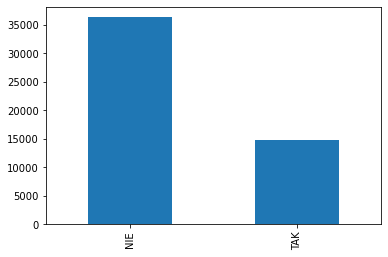

In [48]:
# target niezbalansowany, wiec przy uczeniu mozemy ustawic wagi dla klas i metryka docelowa to F1 score! 
df_train['Churn'].value_counts().plot(kind = 'bar')

#### Transformacja Daty

In [49]:
def date_feature_engineering(df):
    df['data_ostatniej_interakcji'] = pd.to_datetime(df['data_ostatniej_interakcji'],yearfirst=True)
#     df["dayofweek"] = df["data_ostatniej_interakcji"].dt.dayofweek
#     df["dayofyear"] = df["data_ostatniej_interakcji"].dt.dayofyear
#     df["week"] = df["data_ostatniej_interakcji"].dt.week
#     df["month"] = df["data_ostatniej_interakcji"].dt.month
#     df["quarter"] = df["data_ostatniej_interakcji"].dt.quarter
#     df["year"] = df["data_ostatniej_interakcji"].dt.year
    df_final = df.drop(['data_ostatniej_interakcji'],axis = 1)
    return df_final

In [50]:
df_train_date_transformed = date_feature_engineering(df_train)
df_test_date_transformed = date_feature_engineering(df_test)

#### Zastepowanie Nan'ow mediana

In [51]:
df_train_na_filled = df_train_date_transformed.fillna(df_train_date_transformed.median())
df_test_na_filled = df_test_date_transformed.fillna(df_test_date_transformed.median())

#### Zmiana kolumn TAK/NIE na 1/0

In [52]:
object_columns = [column for column in df_train_na_filled.columns if df_train_na_filled[column].dtype == 'object']

def transformacja_stringow(df,object_columns):
    for col in object_columns:
        try:
            df[col] = df[col].apply(lambda x: 1 if x == 'TAK' else 0)
        except:
            print("There is no column:", col )
    return df

In [53]:
df_train_string_transformed = transformacja_stringow(df_train_na_filled,object_columns)
df_test_string_transformed = transformacja_stringow(df_test_na_filled,object_columns)

There is no column: Churn


P-value for column procentowa_zmiana_reve isn too big and is equal: 0.011730788936117278
P-value for column usage_data_MB isn too big and is equal: 0.174833317137826
P-value for column CODE isn too big and is equal: 0.10667163022913517


<BarContainer object of 16 artists>

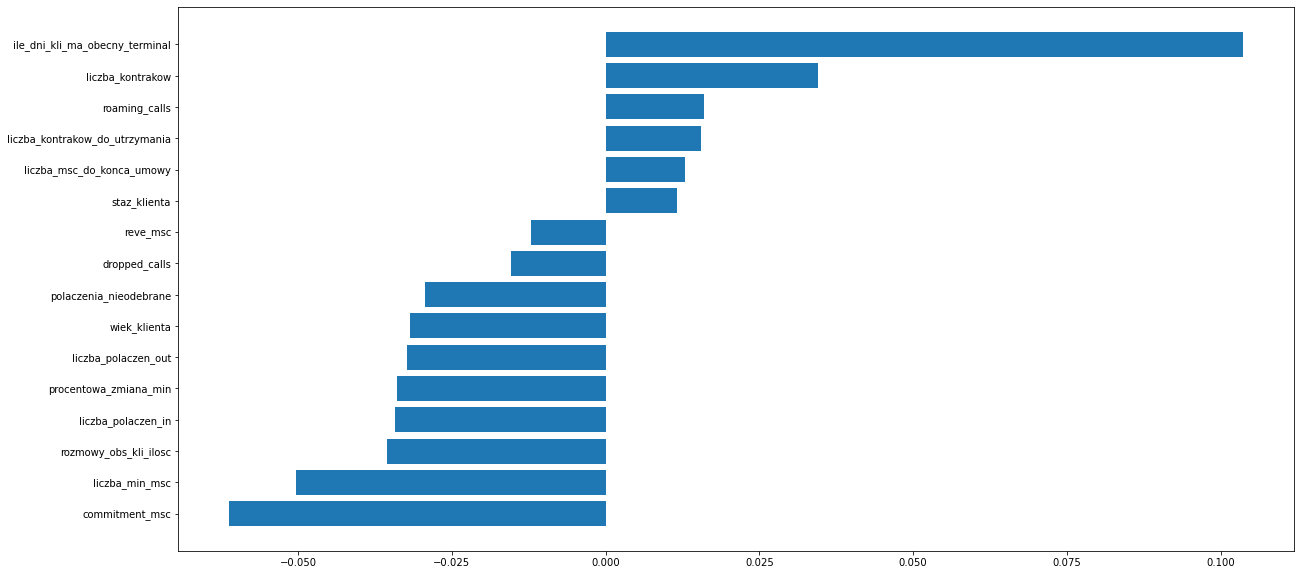

In [54]:
# Sprawdzam korelacje pomiedzy targetem (churn), a innymi zmiennymi.
# Korelacja point biserial zostala zastosowana pomiedzy target (zmienna binarna) a zmienna ciagla

continuos_cols = ['reve_msc','liczba_min_msc', 'commitment_msc', 'roaming_calls', 'procentowa_zmiana_min', 
                  'procentowa_zmiana_reve','dropped_calls','polaczenia_nieodebrane','rozmowy_obs_kli_ilosc',
                  'usage_data_MB','liczba_polaczen_out','liczba_polaczen_in','staz_klienta','liczba_kontrakow',
                  'liczba_kontrakow_do_utrzymania','ile_dni_kli_ma_obecny_terminal','CODE', 'liczba_msc_do_konca_umowy',
                  'wiek_klienta']
pbc_dict = dict()
for col in continuos_cols:
    pbc, pval = pointbiserialr(df_train_string_transformed[col],df_train_string_transformed['Churn'])
    # sprawdzenie czy korelacja jest istotna statystycznie
    if pval < 0.01:
        pbc_dict[col] = pbc
    else:
        print("P-value for column", col, "isn too big and is equal:", pval)
        
#sortowanie
pbc_dict = dict(sorted(pbc_dict.items(), key=lambda item: item[1]))
        
names = list(pbc_dict.keys())
point_biserial_values = list(pbc_dict.values())

plt.figure(figsize = (20,10))
plt.barh(range(len(pbc_dict)),point_biserial_values,tick_label = names )

Otrzymane korelacje sa bardzo slabe (bliskie zeru). Jednakze mozemy minimalnie zauwazyc, ze im wieksze zobowiazanie, tym mniejsza szansa na odejscie klienta oraz im wiecej dni klient ma obecny terminal, tym wieksza szansa na odejscie. Jednak, trzeba pamiętać, że korelacje sa tak niskie, ze wysnuwanie wnioskow nie jest wiarygodne (<b>"correlation is not causation" </b>)  

### Histogramy zmiennych numerycznych

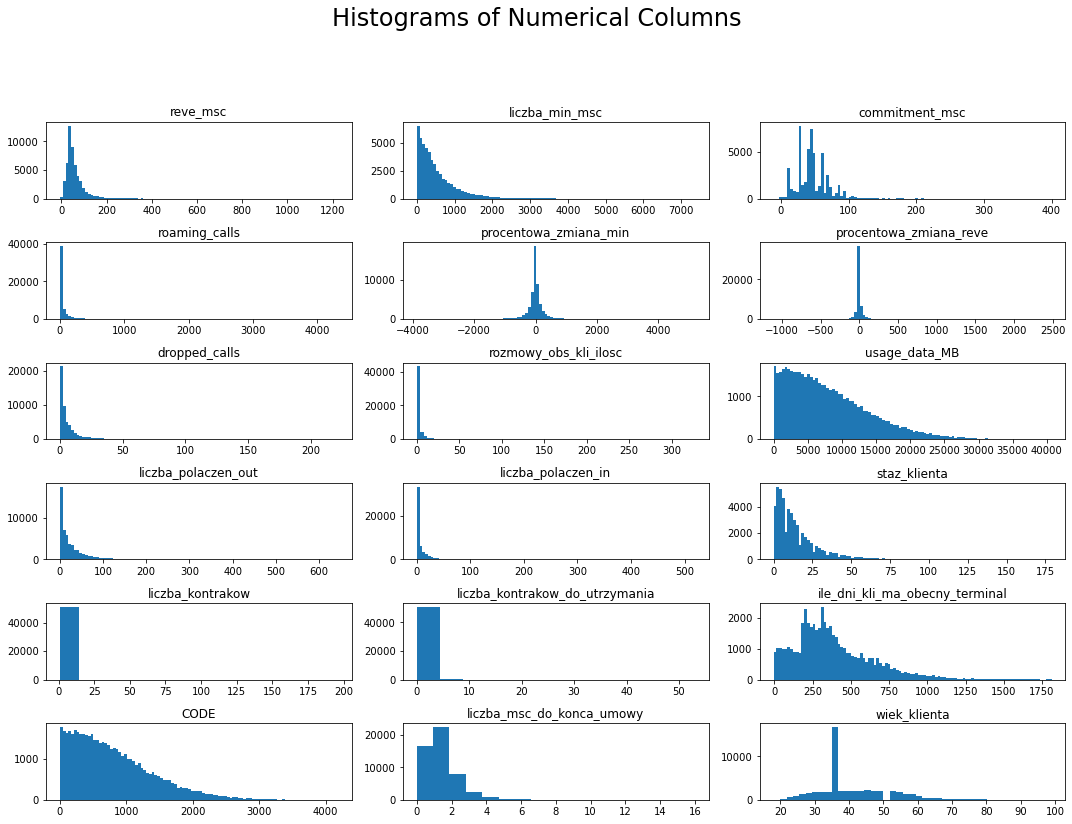

In [55]:
df_temp = df_train_string_transformed[['reve_msc','liczba_min_msc', 'commitment_msc', 'roaming_calls', 'procentowa_zmiana_min', 
                  'procentowa_zmiana_reve','dropped_calls','rozmowy_obs_kli_ilosc',
                  'usage_data_MB','liczba_polaczen_out','liczba_polaczen_in','staz_klienta','liczba_kontrakow',
                  'liczba_kontrakow_do_utrzymania','ile_dni_kli_ma_obecny_terminal','CODE', 'liczba_msc_do_konca_umowy',
                  'wiek_klienta']]
#Histogram:
    
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Histograms of Numerical Columns\n',horizontalalignment="center",fontstyle = "normal", fontsize = 24, fontfamily = "sans-serif")
for i in range(df_temp.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(df_temp.columns.values[i])
    
    vals = np.size(df_temp.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    
    plt.hist(df_temp.iloc[:, i], bins=vals)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Kilka podstawowych obserwacji:
- niektore kolumny mozemy zlogarytmowac, poniewaz widzimy skosnosc (skewness)
- mamy przewazajacy wiek pomiedzy 30 a 40 lat
- w zbiorze sa glownie klienci ktorzy maja od 1 do 15 kontrakow
- usage_data_MB ma bardzo podobny ksztalt do CODE i ma wartosci 10 razy wieksze
- wiekszosci klientow w zbiorze konczy sie umowa za mniej niz 3 miesiace
- staz klienta -> wiekszosc klientow to nowi klienci
- miesieczne zobowiazanie znajduja sie glownie w przedziale od 10 do 100, sa pewne wieksze grupy zobowiazan. Dodatkowo pojawiaja sie ujemne wartosci, przydalaby sie konsultacja z zespolem z czego to wynika. To moga byc na przyklad anomalie.

### Bar ploty zmiennych kategorycznych

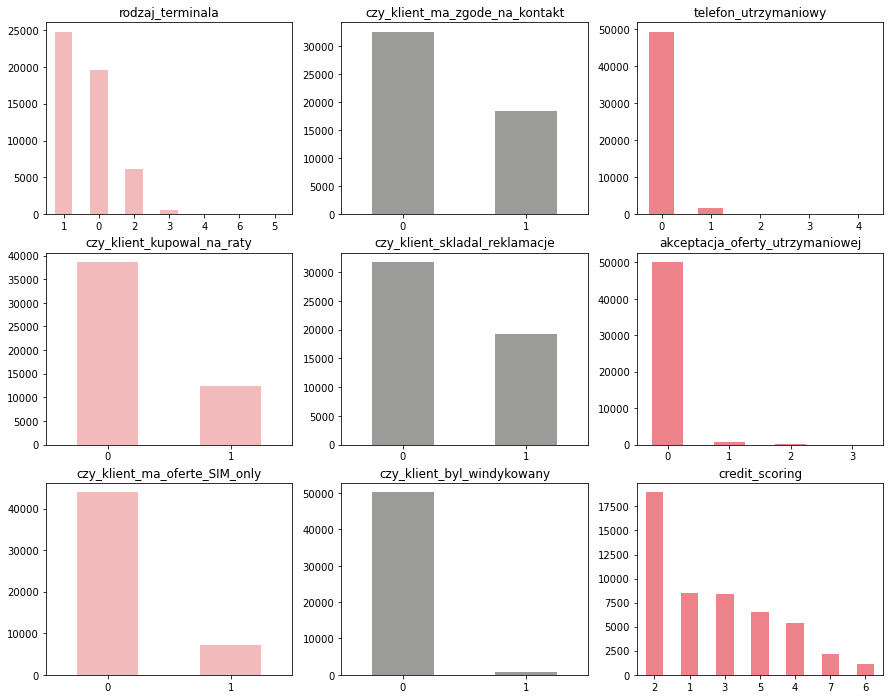

In [56]:
categorical= ['rodzaj_terminala','czy_klient_kupowal_na_raty','czy_klient_ma_oferte_SIM_only',
              'czy_klient_ma_zgode_na_kontakt','czy_klient_skladal_reklamacje','czy_klient_byl_windykowany',
              'telefon_utrzymaniowy','akceptacja_oferty_utrzymaniowej','credit_scoring']
fig, axes = plt.subplots(nrows = 3,ncols = 3,
figsize = (15,12))
for i, item in enumerate(categorical):
    if i < 3:
        ax = df_train_string_transformed[item].value_counts().plot(
        kind = 'bar',ax=axes[i,0],
        rot = 0, color ='#f3babc' )
        
    elif i >=3 and i < 6:
        ax = df_train_string_transformed[item].value_counts().plot(
        kind = 'bar',ax=axes[i-3,1],
        rot = 0,color ='#9b9c9a')
        
    elif i < 9:
        ax = df_train_string_transformed[item].value_counts().plot(
        kind = 'bar',ax=axes[i-6,2],rot = 0,
        color = '#ec838a')
    ax.set_title(item)

Kilka podstawowych obserwacji:
- malo klientow bylo windykowanych
- malo klientow ma oferte SIM only
- wiekszosc klientow ma credit_scoring = 2
- mniej klientow kupywalo na raty
- terminale 1 i 0 przewazaja
- wiekszosc wartosci w telefonie utrzymaniowym to 0 i tak samo w akceptacji

### Churn w zaleznosci od  Liczba kontrakow

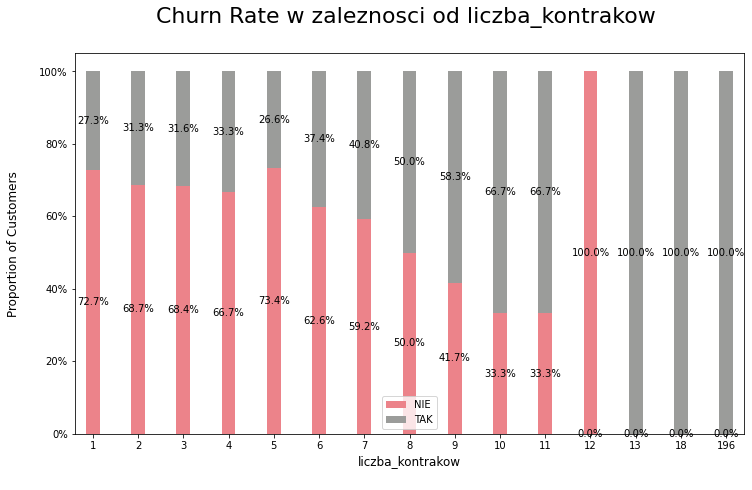

In [57]:
import matplotlib.ticker as mtick
temp =df_train_string_transformed.groupby(['liczba_kontrakow','Churn']).size().unstack()
temp.rename(columns={0:'NIE', 1:'TAK'}, inplace=True)
colors  = ['#ec838a','#9b9c9a']
ax = (temp.T*100.0 / temp.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),color = colors)
plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('liczba_kontrakow\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate w zaleznosci od liczba_kontrakow \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

Im wieksza liczba kontrakow tym wiekszy churn rate, wyjatkiem jest liczba_kontrakow rowna 12

### Churn w zaleznosci od Credit Scoring

C:\Users\agole\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='credit_scoring', ylabel='count'>

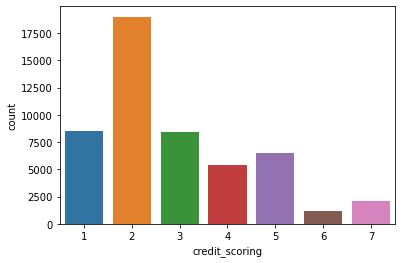

In [58]:
sns.countplot(df_train_string_transformed['credit_scoring'])

Wiekszosc klientow ma Credit Scoring rowny 2

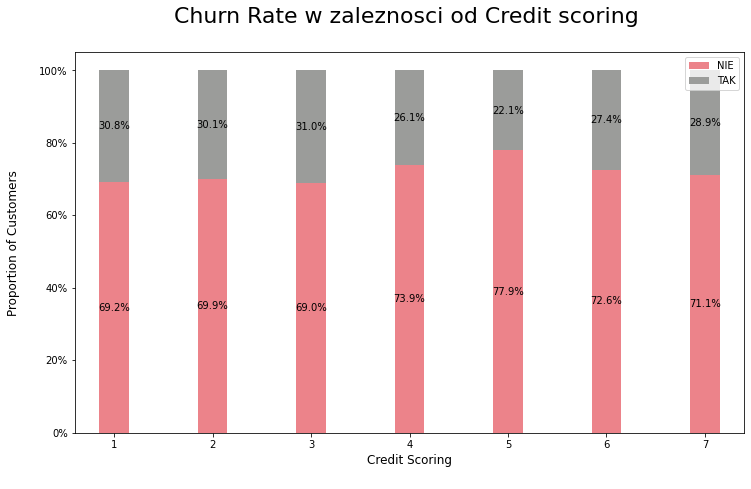

In [59]:
import matplotlib.ticker as mtick
temp =df_train_string_transformed.groupby(['credit_scoring','Churn']).size().unstack()
temp.rename(columns={0:'NIE', 1:'TAK'}, inplace=True)
colors  = ['#ec838a','#9b9c9a']
ax = (temp.T*100.0 / temp.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),color = colors)
plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Credit Scoring\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate w zaleznosci od Credit scoring \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

Najmniejszy churn rate jest gdy credit scoring wynosi 5 

### Churn w zaleznosci Czy klient byl windykowany

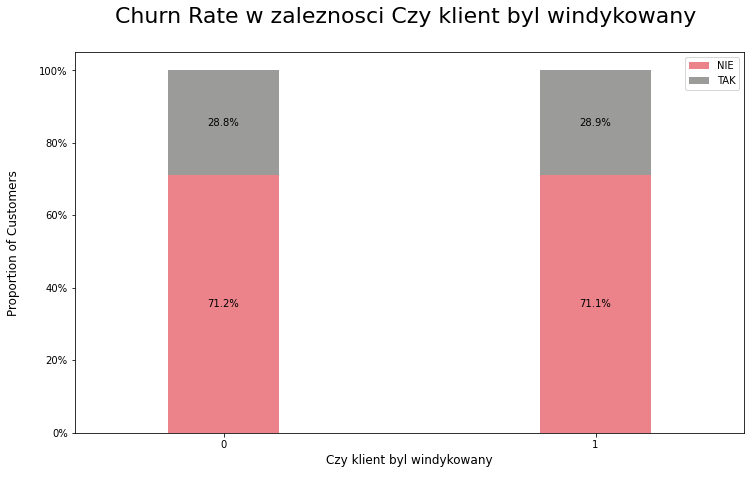

In [60]:
import matplotlib.ticker as mtick
temp =df_train_string_transformed.groupby(['czy_klient_byl_windykowany','Churn']).size().unstack()
temp.rename(columns={0:'NIE', 1:'TAK'}, inplace=True)
colors  = ['#ec838a','#9b9c9a']
ax = (temp.T*100.0 / temp.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),color = colors)
plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Czy klient byl windykowany\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate w zaleznosci Czy klient byl windykowany \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

Identyczne proporcje, informacja czy klient byl windykowany nie przedstawia zadnej roznicy w zmiennej docelowej

### Churn w zaleznosci od rodzaju terminala

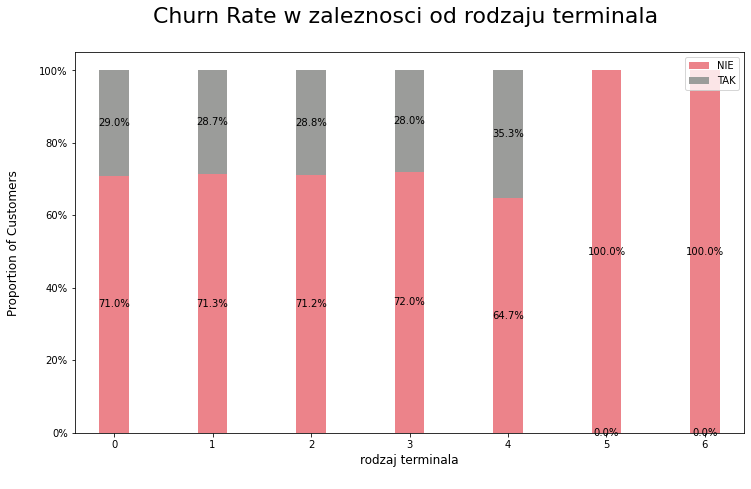

In [61]:
import matplotlib.ticker as mtick
temp =df_train_string_transformed.groupby(['rodzaj_terminala','Churn']).size().unstack()
temp.rename(columns={0:'NIE', 1:'TAK'}, inplace=True)
colors  = ['#ec838a','#9b9c9a']
ax = (temp.T*100.0 / temp.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),color = colors)
plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('rodzaj terminala\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate w zaleznosci od rodzaju terminala \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

Gdy rodzaj terminala wynosi 5 lub 6 to churn nie wystepuje

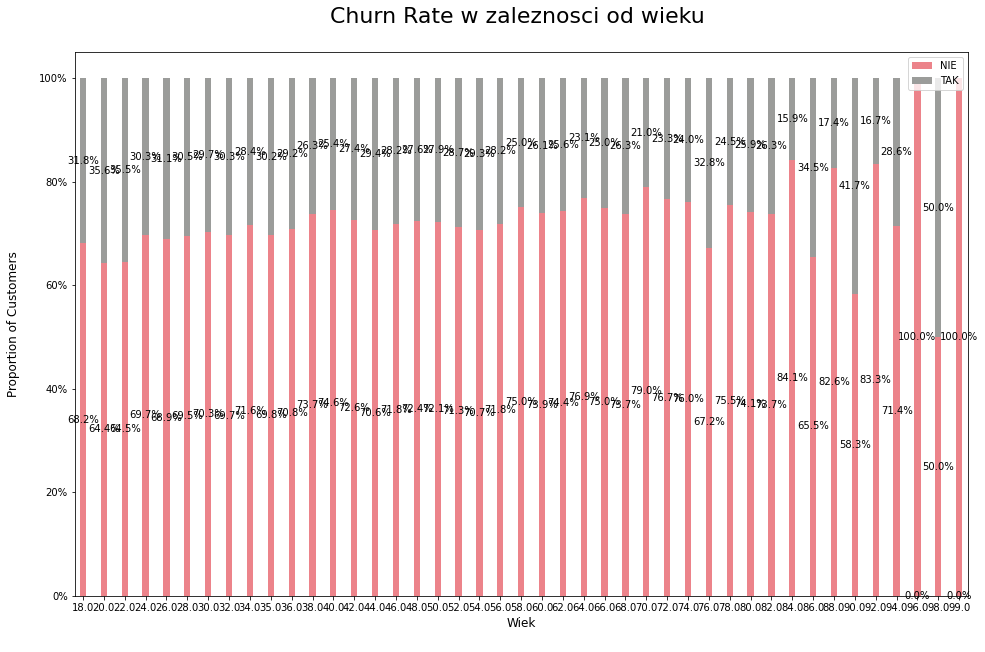

In [62]:
import matplotlib.ticker as mtick
temp =df_train_string_transformed.groupby(['wiek_klienta','Churn']).size().unstack()
temp.rename(columns={0:'NIE', 1:'TAK'}, inplace=True)
colors  = ['#ec838a','#9b9c9a']
ax = (temp.T*100.0 / temp.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (16,10),color = colors)
plt.ylabel('Proportion of Customers\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Wiek\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Churn Rate w zaleznosci od wieku \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

Im wyzszy wiek klienta tym mniejszy churn rate. Warto stworzyc kategorie 18-22, 23-58, 59+

EDA Wnioski:
- Otrzymane korelacje sa bardzo slabe (bliskie zeru). Jednakze mozemy minimalnie zauwazyc, ze im wieksze zobowiazanie, tym mniejsza szansa na odejscie klienta oraz im wiecej dni klient ma obecny terminal, tym wieksza szansa na odejscie. Jednak, trzeba pamiętać, że korelacje sa tak niskie, ze wysnuwanie wnioskow nie jest wiarygodne (<b>"correlation is not causation" </b>)   
- niektore kolumny mozemy zlogarytmowac, poniewaz widzimy skosnosc (skewness)
- mamy przewazajacy wiek pomiedzy 30 a 40 lat
- w zbiorze sa glownie klienci ktorzy maja od 1 do 15 kontrakow
- usage_data_MB ma bardzo podobny ksztalt do CODE i ma wartosci 10 razy wieksze
- wiekszosci klientow w zbiorze konczy sie umowa za mniej niz 3 miesiace
- staz klienta -> wiekszosc klientow to nowi klienci
- miesieczne zobowiazanie znajduja sie glownie w przedziale od 10 do 100, sa pewne wieksze grupy zobowiazan. Dodatkowo pojawiaja sie ujemne wartosci, przydalaby sie konsultacja z zespolem z czego to wynika. To moga byc na przyklad anomalie.
- malo klientow bylo windykowanych
- malo klientow ma oferte SIM only
- wiekszosc klientow ma credit_scoring = 2
- mniej klientow kupywalo na raty
- terminale 1 i 0 przewazaja
- wiekszosc wartosci w telefonie utrzymaniowym to 0 i tak samo w akceptacji
- Im wieksza liczba kontrakow tym wiekszy churn rate
- Gdy rodzaj terminala wynosi 5 lub 6 to churn nie wystepuje
- Identyczne proporcje, informacja czy klient byl windykowany nie przedstawia zadnej roznicy w zmiennej docelowej
- Najmniejszy churn rate jest gdy credit scoring wynosi 5 
- Wiekszosc klientow ma Credit Scoring rowny 2
- Im wyzszy wiek klienta tym mniejszy churn rate. Warto stworzyc kategorie 18-22, 23-58, 59+

# Przygotowanie Danych

#### Outlierzy

In [63]:
def removing_outliers(df):
    no_rows_begin = df.shape[0]
    
    df_transform0 = df[(df['reve_msc'] <= 700) & (df['reve_msc'] >= 0)]
    print('Number of deleted rows:',no_rows_begin - df_transform0.shape[0])
    
    df_transform1 = df_transform0[df_transform0['commitment_msc'] >= 0]
    print('Number of deleted rows:',no_rows_begin - df_transform1.shape[0])
    
    df_transform2 = df_transform1[df_transform1['liczba_kontrakow'] != 196]
    print('Number of deleted rows:',no_rows_begin - df_transform2.shape[0])
    
    df_final = df_transform2[df_transform2['ile_dni_kli_ma_obecny_terminal'] > 0]
    print('Percent of deleted rows comparing to default data:',round((((no_rows_begin - df_final.shape[0])/no_rows_begin)*100),2), '%')
    
    return df_final

In [64]:
df_train_without_outliers = removing_outliers(df_train_string_transformed)

Number of deleted rows: 11
Number of deleted rows: 17
Number of deleted rows: 18
Percent of deleted rows comparing to default data: 0.23 %


###  Sprawdzenie wspolliniowosci (multicollinearity) uzywajac VIF

In [65]:
def calc_vif(df):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)


In [66]:
calc_vif(df_train_without_outliers.drop(['KLIENT_ID'],axis = 1))

,variables,VIF
0,Churn,1.432317
1,reve_msc,22.969757
2,liczba_min_msc,8.064200
3,commitment_msc,16.102521
4,roaming_calls,6.005739
5,procentowa_zmiana_min,1.655851
6,procentowa_zmiana_reve,1.642206
7,dropped_calls,2.541828
8,polaczenia_nieodebrane,3.085045
9,rozmowy_obs_kli_ilosc,1.451523


In [67]:
# Po usunieciu KLIENT_ID,reve_msc,liczba_kontrakow_do_utrzymania i czy_klient_ma_zgode_na_kontakt 
# pozbywamy sie w duzej mierze wspoliniowosci
df_train_dropped_cols_multilinearity = df_train_without_outliers.drop(['KLIENT_ID','reve_msc','liczba_min_msc',
                                                                         'liczba_kontrakow_do_utrzymania',
                                                                         'czy_klient_ma_zgode_na_kontakt'],axis = 1)
klient_id = df_test_string_transformed['KLIENT_ID']
df_test_dropped_cols_multilinearity = df_test_string_transformed.drop(['KLIENT_ID','reve_msc','liczba_min_msc',
                                                                         'liczba_kontrakow_do_utrzymania',
                                                                         'czy_klient_ma_zgode_na_kontakt'],axis = 1)
calc_vif(df_train_dropped_cols_multilinearity)

,variables,VIF
0,Churn,1.430931
1,commitment_msc,5.483702
2,roaming_calls,1.474304
3,procentowa_zmiana_min,1.654480
4,procentowa_zmiana_reve,1.640059
5,dropped_calls,2.453847
6,polaczenia_nieodebrane,2.910773
7,rozmowy_obs_kli_ilosc,1.400799
8,usage_data_MB,2.654310
9,liczba_polaczen_out,4.460825


#### Logarytmizacja


In [68]:
# Logarytmizujemy kolumny
# columns_to_log = ['reve_msc','roaming_calls','dropped_calls','polaczenia_nieodebrane','usage_data_MB','liczba_polaczen_out',
#                   'liczba_polaczen_in','staz_klienta','CODE','ile_dni_kli_ma_obecny_terminal']
columns_to_log = ['roaming_calls','dropped_calls','polaczenia_nieodebrane','usage_data_MB','liczba_polaczen_out',
                  'liczba_polaczen_in','staz_klienta','CODE','ile_dni_kli_ma_obecny_terminal']

def logarytmizacja(df,columns_to_log):
    for col in columns_to_log:
        df[col] = np.log(df[col] - (df[col].min() - 1))
    return df

In [69]:
df_train_logarithmed = logarytmizacja(df_train_dropped_cols_multilinearity,columns_to_log)
df_test_logarithmed = logarytmizacja(df_test_dropped_cols_multilinearity,columns_to_log)

#### Utworzenie grup wiekowych

In [70]:
# warto stworzyc kategorie 18-22, 23-58, 59+
def transformacja_wieku(df):
    df["wiek_22"] = df['wiek_klienta'].apply(lambda x: 1 if x <= 22 else 0)
    df["58_wiek_23"] = df['wiek_klienta'].apply(lambda x: 1 if (x <= 58) & (x >=23) else 0)
    df["wiek_59plus"] = df['wiek_klienta'].apply(lambda x: 1 if x >=59 else 0)
    df.drop(['wiek_klienta'],axis = 1, inplace = True)
    
    return df


In [71]:
transformacja_wieku(df_train_logarithmed)
transformacja_wieku(df_test_logarithmed)

,commitment_msc,roaming_calls,procentowa_zmiana_min,procentowa_zmiana_reve,dropped_calls,polaczenia_nieodebrane,rozmowy_obs_kli_ilosc,usage_data_MB,liczba_polaczen_out,liczba_polaczen_in,staz_klienta,liczba_msc_do_konca_umowy,liczba_kontrakow,CODE,rodzaj_terminala,ile_dni_kli_ma_obecny_terminal,czy_klient_kupowal_na_raty,czy_klient_ma_oferte_SIM_only,czy_klient_skladal_reklamacje,czy_klient_byl_windykowany,telefon_utrzymaniowy,akceptacja_oferty_utrzymaniowej,credit_scoring,wiek_22,58_wiek_23,wiek_59plus
0,37.0,3.178054,532.0,51.0,2.230014,4.131961,2,8.764366,3.850148,1.945910,4.700480,1,1,6.436150,2,5.505332,0,0,1,0,0,0,5,0,1,0
1,72.0,0.000000,38.0,0.0,2.370244,4.356709,9,9.886341,2.772589,0.693147,3.871201,0,1,6.683361,1,6.086775,0,0,0,0,0,0,1,0,1,0
2,50.0,6.042633,198.0,23.3,2.617396,5.176150,11,9.806316,4.644391,0.000000,4.060443,1,1,6.003887,2,6.559615,0,0,0,0,0,0,3,0,1,0
3,30.0,2.833213,30.0,7.3,1.098612,2.906901,0,9.437396,2.197225,1.791759,3.401197,4,3,5.937536,1,3.988984,1,0,1,1,0,0,1,0,1,0
4,50.0,0.000000,169.0,1.0,1.308333,3.799974,4,8.880864,3.951244,2.197225,4.025352,1,1,5.765191,0,6.025866,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,88.0,0.693147,0.0,0.0,2.564949,2.791165,0,8.151045,2.302585,1.386294,2.995732,3,3,6.366470,1,5.463832,0,0,0,0,0,0,1,0,0,1
19996,45.0,1.098612,-4.0,-0.3,0.000000,1.098612,0,9.233764,0.000000,0.000000,3.218876,0,1,3.044522,1,6.658011,0,0,0,0,0,0,1,0,1,0
19997,45.0,1.098612,-4.0,-0.3,0.000000,0.000000,0,7.896925,0.693147,0.000000,2.564949,1,1,4.779123,1,6.658011,0,0,0,0,0,0,1,0,1,0
19998,45.0,1.098612,-4.0,-0.3,2.995732,3.321432,4,5.950643,3.583519,1.386294,2.302585,0,1,6.549651,1,3.637586,0,0,0,0,0,0,3,0,1,0


#### Dummy variables

In [72]:
df_train_final = df_train_logarithmed
df_test_final = df_test_logarithmed

In [73]:
print(df_train_final.shape)
print(df_test_final.shape)

(50931, 27)
(20000, 26)


# Modelowanie

Uzyje danych treningowych jako dane treningowe i walidacyjne 

In [74]:
X = df_train_final.drop(['Churn'],axis = 1)
y = df_train_final['Churn']

## Podstawowe modele Klasyfikacyjne

In [75]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [76]:
scores = []
names = []
models = []

models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0,class_weight='balanced')))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5)))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(class_weight='balanced',random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(class_weight='balanced',random_state=0)))
models.append(('XGBoost', XGBClassifier(scale_pos_weight = y[y==0].count()/y[y==1].count(),
                                        use_label_encoder=False, objective='binary:logistic',verbosity = 0)))

col = ['Algorithm','F1 Score Mean', 'F1 Score Std', 'Recall Mean', 'Precision Mean']
model_results = pd.DataFrame(columns=col)

i = 0

# Oceniam model metrykami F1,Precision,Recall przy uzyciu stratified k-fold:
for name, model in tqdm(models):    

    f1_results = []
    recall_results = []
    precision_results = []

    #scores = []
    for train_idx, test_idx in skf.split(X,y):
        scaler = MinMaxScaler()
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_normalized = scaler.fit_transform(X_train)
        X_test_normalized = scaler.transform(X_test)
        
        model.fit(X_train_normalized, y_train)
        y_pred = model.predict(X_test_normalized)
        
        # F1 score
        f1_score_ = f1_score(y_test, y_pred)
        
        # Recall score - proporcja klientow ktorzy zostali pozytywnie zidentyfikowani ze odejda
        # do klientow ktorzy faktycznie odeszli 
        recall_score_ = recall_score(y_test, y_pred)
        
        # Precision score - proporcja klientow ktorzy zostali pozytywnie zidentyfikowani ze odejda 
        # do wszystkich ktorych tak zidentyfikowalismy
        precision_score_ = precision_score(y_test, y_pred)
        
        
        f1_results.append(f1_score_)
        recall_results.append(recall_score_)
        precision_results.append(precision_score_)
    
    names.append(name)    
    scores.append(f1_results)
    model_results.loc[i] = [name,
                            round(np.mean(f1_results)*100, 2),
                            round(np.std(f1_results)*100, 2),
                            round(np.mean(recall_results)*100, 2),
                            round(np.mean(precision_results)*100, 2)]
    i += 1

model_results.sort_values(by=['F1 Score Mean'], ascending=False)

100%|██████████| 6/6 [03:17<00:00, 32.92s/it]


,Algorithm,F1 Score Mean,F1 Score Std,Recall Mean,Precision Mean
0,Logistic Regression,44.68,0.22,59.70,35.70
5,XGBoost,44.29,0.63,52.90,38.09
3,Decision Tree Classifier,33.38,1.11,33.40,33.37
1,KNN,23.12,0.57,17.66,33.48
2,Gaussian NB,17.04,1.30,10.89,39.35
4,Random Forest,10.34,0.54,5.72,54.08


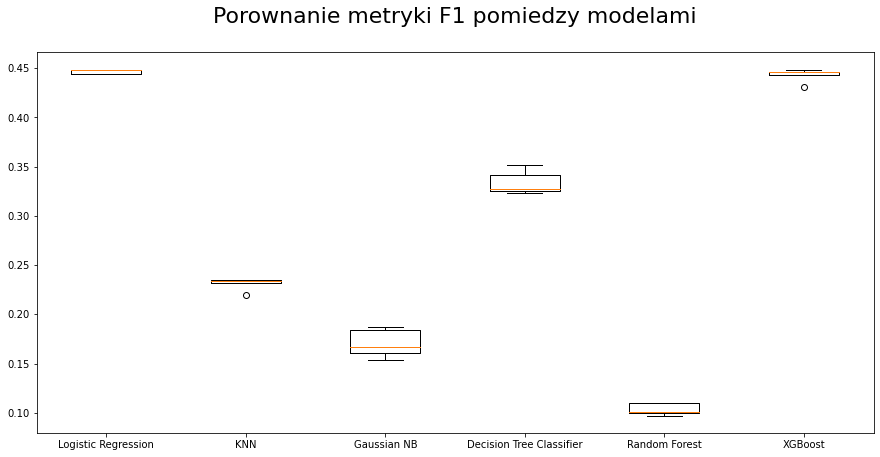

In [77]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

plt.title('Porownanie metryki F1 pomiedzy modelami\n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

 XGBoost wraz z Regresja Logistyczna osiagnely najlepsze wyniki sposrod wszystkich algorytmow.

### Znalezienie optymalnej liczby k sadiadow w KNN 

100%|██████████| 9/9 [02:52<00:00, 19.12s/it]


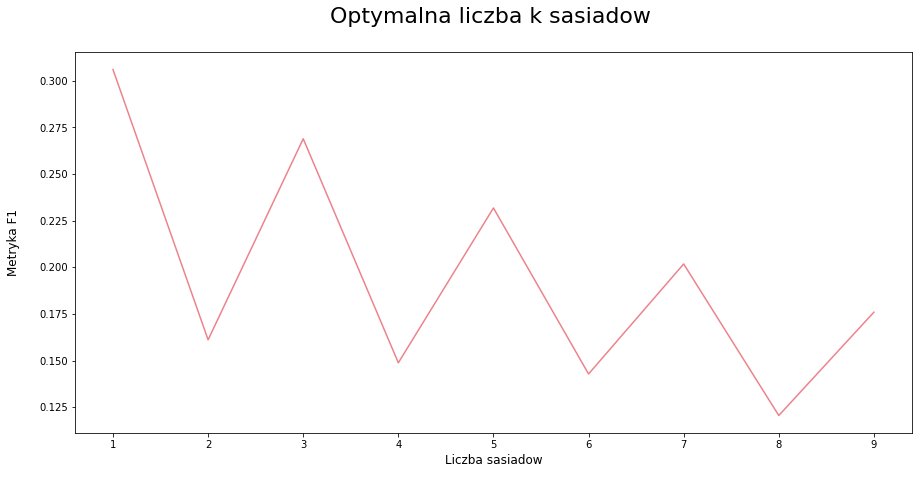

In [80]:
f1_array = []
for k in tqdm(range(1,10)):
    knn_loop = KNeighborsClassifier(n_neighbors = k) 
    knn_loop.fit(X_train_normalized,y_train)
    y_pred = knn_loop.predict(X_test_normalized)
    
    f1_array.append(f1_score(y_test, y_pred))
    
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,10),f1_array, color = '#ec838a')
plt.ylabel('Metryka F1\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Liczba sasiadow\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large",fontfamily = "sans-serif")
plt.title('Optymalna liczba k sasiadow \n',horizontalalignment="center", fontstyle = "normal",fontsize = "22", fontfamily = "sans-serif")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Optymalna ilosc sadiadow wynosi 1.

### Znalezienie optymalnej liczby drzew dla XGBoost

100%|██████████| 30/30 [02:54<00:00,  5.83s/it]


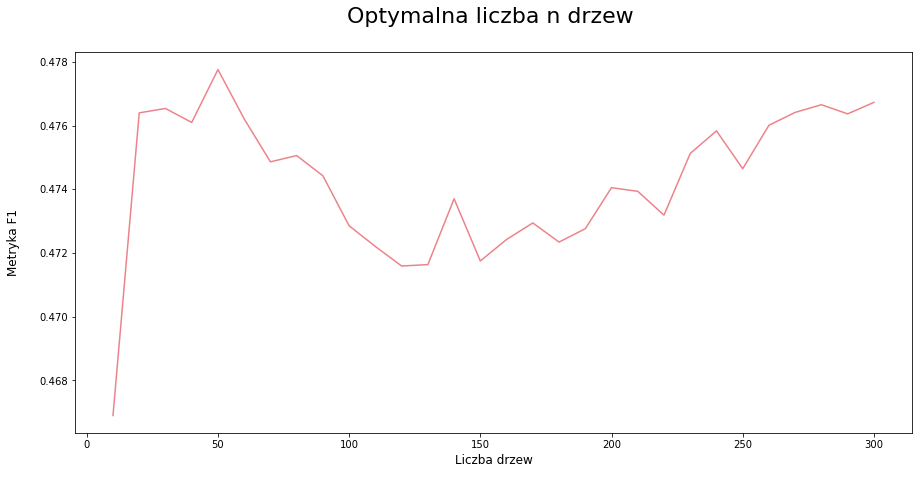

In [61]:
f1_array = []
for n in tqdm(range(10,301,10)):
    xgb_loop = XGBClassifier(n_estimators = n,learning_rate = 0.01,scale_pos_weight = y[y==0].count()/y[y==1].count(),
                  use_label_encoder=False, objective='binary:logistic',verbosity = 0) 
    xgb_loop.fit(X_train_normalized,y_train)
    y_pred = xgb_loop.predict(X_test_normalized)
    
    f1_array.append(f1_score(y_test, y_pred))
    
fig = plt.figure(figsize=(15, 7))
plt.plot(range(10,301,10),f1_array, color = '#ec838a')
plt.ylabel('Metryka F1\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Liczba drzew\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large",fontfamily = "sans-serif")
plt.title('Optymalna liczba n drzew \n',horizontalalignment="center", fontstyle = "normal",fontsize = "22", fontfamily = "sans-serif")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Optymalna liczba drzew wynosi 60

#### WNIOSEK:
- XGBoost wraz z Regresja Logistyczna uzyskaly najlepsze wyniki F1. W dalszej częsci skupie się tylko na XGBoost, jednak mozna rowniez zoptymalizowac model regresji logistycznej jak i inne modele

### Sprawdzenie waznosci cech (Feature Importance) dla modelu XGBoost

In [62]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X)
y_train = y

In [63]:
m = XGBClassifier(n_estimators = 60,scale_pos_weight = y[y==0].count()/y[y==1].count(),learning_rate = 0.01,
                  use_label_encoder=False, objective='binary:logistic',verbosity = 0)
m.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.4677606046163274,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [64]:
feats = list(X.columns)
perm = PermutationImportance(m,random_state= 0).fit(X_train,y_train)
result = eli5.show_weights(perm,feature_names = feats, top = len(feats))
result

Weight,Feature
0.0676 ± 0.0038,ile_dni_kli_ma_obecny_terminal
0.0468 ± 0.0019,procentowa_zmiana_min
0.0328 ± 0.0026,commitment_msc
0.0325 ± 0.0026,usage_data_MB
0.0295 ± 0.0035,procentowa_zmiana_reve
0.0277 ± 0.0014,dropped_calls
0.0265 ± 0.0013,CODE
0.0264 ± 0.0007,polaczenia_nieodebrane
0.0234 ± 0.0008,staz_klienta
0.0215 ± 0.0013,roaming_calls


Najwazniejszymi zmiennymi dla modelu XGBoost okazaly sie byc: <b> procentowa_zmiana_min,ile_dni_kli_ma_obecny_terminal,commitment_msc

In [65]:
important_feats = ['procentowa_zmiana_min','ile_dni_kli_ma_obecny_terminal','commitment_msc',
                   'dropped_calls','procentowa_zmiana_reve','usage_data_MB','CODE','polaczenia_nieodebrane',
                   'staz_klienta','roaming_calls','liczba_polaczen_out','liczba_kontrakow','liczba_polaczen_in',
                   'rozmowy_obs_kli_ilosc']

### Poprawa modelu XGBoost poprzez przeszukiwanie przestrzeni parametrow przy uzyciu hyperopt

In [66]:
def run_model(model,X,y):
    scaler = MinMaxScaler()
    scores = []    
    for train_idx, test_idx in skf.split(X,y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_normalized = scaler.fit_transform(X_train)
        X_test_normalized = scaler.transform(X_test)

        model.fit(X_train_normalized, y_train)
        y_pred = model.predict(X_test_normalized)

        score = f1_score(y_test,y_pred)
        scores.append(score)

    return round(np.mean(scores)*100,2)

In [67]:
def obj_func(params):
    print(params)
    
    f1score = run_model(XGBClassifier(**params),X,y)
    
    return{'loss': -f1score, 'status': STATUS_OK}

In [68]:
xgb_reg_params = {
'learning_rate':     hp.choice('learning_rate',          np.arange(0.005,0.1,0.01)),
'max_depth':         hp.choice("max_depth",              np.arange(3,10,1,dtype = int)),
'objective' : 'binary:logistic',
'n_estimators': 120,
'use_label_encoder': False,
'scale_pos_weight': y_train[y_train==0].count()/y_train[y_train==1].count(),
'verbosity': 0,
'seed': 0
    }
best = fmin(obj_func,xgb_reg_params,algo = tpe.suggest,max_evals = 100)

{'learning_rate': 0.06499999999999999, 'max_depth': 6, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.08499999999999999, 'max_depth': 7, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.024999999999999998, 'max_depth': 6, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.034999999999999996, 'max_depth': 9, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 

{'learning_rate': 0.034999999999999996, 'max_depth': 7, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.075, 'max_depth': 3, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.054999999999999986, 'max_depth': 4, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.005, 'max_depth': 6, 'n_estimators': 120, 'objective': 'binary:logistic', 'scale_pos_weight': 2.4677606046163274, 'seed': 0, 'use_label_encoder': False, 'verbosity': 0}
{'learning_rate': 0.08499

In [69]:
space_eval(xgb_reg_params,best)

{'learning_rate': 0.08499999999999999,
 'max_depth': 4,
 'n_estimators': 120,
 'objective': 'binary:logistic',
 'scale_pos_weight': 2.4677606046163274,
 'seed': 0,
 'use_label_encoder': False,
 'verbosity': 0}

Dla powyzszych parametrow uzyskano najwyzszy wynik 47.9 dla metryki F1. Sprawdzmy confusion matrix.

<Figure size 720x576 with 0 Axes>

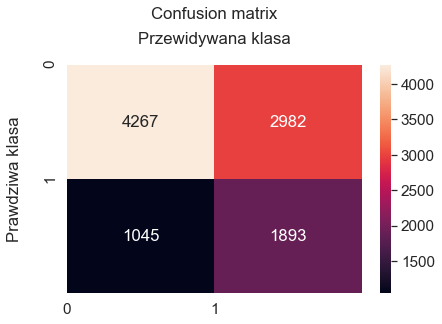

<Figure size 720x576 with 0 Axes>

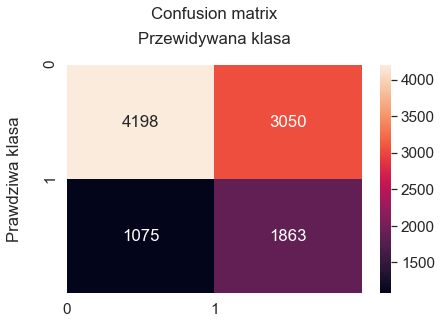

<Figure size 720x576 with 0 Axes>

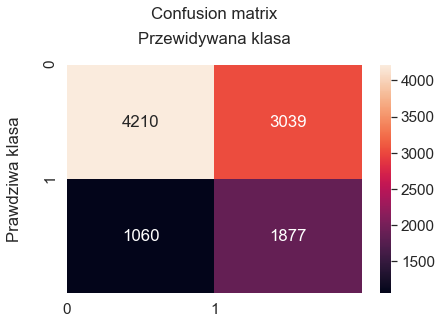

<Figure size 720x576 with 0 Axes>

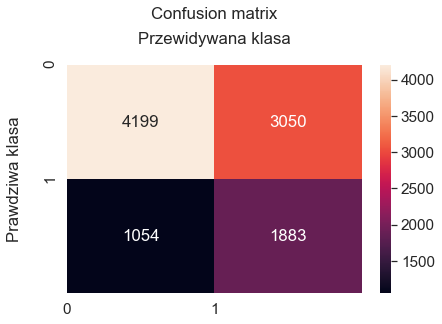

<Figure size 720x576 with 0 Axes>

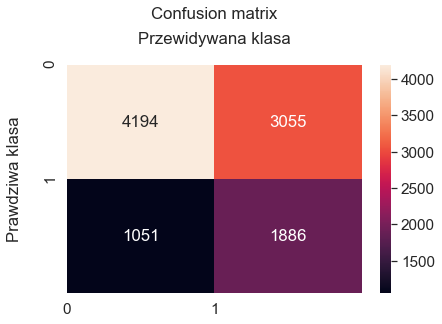

Metryka F1 wynosi: 47.89


In [121]:
scaler = MinMaxScaler()
scores = []    
model = XGBClassifier(learning_rate= 0.085, max_depth = 4, n_estimators = 120,objective = 'binary:logistic',
                              scale_pos_weight = y_train[y_train==0].count()/y_train[y_train==1].count(),
                              use_label_encoder = False,verbosity = 0)
for train_idx, test_idx in skf.split(X,y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    model.fit(X_train_normalized, y_train)
    y_pred = model.predict(X_test_normalized)

    score = f1_score(y_test,y_pred)
    scores.append(score)
    print("======================")
    cm = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
    plt.figure(figsize = (10,8))
    fig, ax = plt.subplots()
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True)
    class_names=[0,1]
    tick_marks = np.arange(len(class_names))
    plt.tight_layout()
    plt.title('Confusion matrix\n', y=1.1)
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    ax.xaxis.set_label_position("top")
    plt.ylabel('Prawdziwa klasa\n')
    plt.xlabel('Przewidywana klasa\n')
    plt.show()
    print("======================")
    
print("Metryka F1 wynosi:", round(np.mean(scores)*100,2))

## Predykcja dla niewidzianych wczesniej danych

In [92]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X)
X_test_normalized = scaler.transform(df_test_final)
y_train = y

In [93]:
model_xgb = XGBClassifier(learning_rate= 0.085, max_depth = 4, n_estimators = 120,objective = 'binary:logistic',
                              scale_pos_weight = y_train[y_train==0].count()/y_train[y_train==1].count(),
                              use_label_encoder = False,verbosity = 0)
model_xgb.fit(X_train_normalized, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.085, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.4677606046163274,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [94]:
y_pred = model_xgb.predict(X_test_normalized)

In [113]:
df_test_final_predicted = pd.concat([klient_id,df_test_final,pd.DataFrame(y_pred,columns = ['Churn'])],axis = 1)

In [115]:
# zapisywanie do formatu csv
df_test_final_predicted.to_csv('AdrianGolebaPredykcjaChurn.csv')

### Sieci Neuronowe (Dodatkowo)

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [106]:
from tensorflow.keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [107]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scaler = MinMaxScaler()
scores = []

for train_idx, test_idx in tqdm(skf.split(X,y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
    X_test_normalized = pd.DataFrame(scaler.transform(X_test))
    
    input_shape = X_train_normalized.shape[1]
    
    model = Sequential()
    
    model.add(Dense(input_shape,activation = 'relu'))
    model.add(Dense(100,activation = 'relu'))
#     model.add(Dense(200,activation = 'relu'))
#     model.add(Dense(200,activation = 'relu'))
#     model.add(Dense(100,activation = 'relu'))
    model.add(Dense(1,activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = [f1_m])
    
    model.fit(X_train_normalized, y_train, epochs=10,batch_size = 32)
    y_pred = model.predict(X_test_normalized)
    
    f1score = f1_score(y_test, y_pred)
    scores.append(f1score)
    #print(classification_report(y_test, y_pred))
np.mean(scores)

0it [00:00, ?it/s]

Epoch 1/10
1274/1274 [==============================] - 3s 1ms/step - loss: 0.5999 - f1_m: 0.4413
Epoch 2/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5900 - f1_m: 0.4434
Epoch 3/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5867 - f1_m: 0.4419
Epoch 4/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5821 - f1_m: 0.4400
Epoch 5/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5833 - f1_m: 0.4410
Epoch 6/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5836 - f1_m: 0.4392
Epoch 7/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5827 - f1_m: 0.4431
Epoch 8/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5807 - f1_m: 0.4384
Epoch 9/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5787 - f1_m: 0.4374
Epoch 10/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5809 - f1_m: 0.4421


1it [00:19, 19.39s/it]

Epoch 1/10
1274/1274 [==============================] - 3s 1ms/step - loss: 0.6034 - f1_m: 0.4420
Epoch 2/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5868 - f1_m: 0.4377
Epoch 3/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5881 - f1_m: 0.4419
Epoch 4/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5825 - f1_m: 0.4375
Epoch 5/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5840 - f1_m: 0.4406
Epoch 6/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5877 - f1_m: 0.4464
Epoch 7/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5870 - f1_m: 0.4468
Epoch 8/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5802 - f1_m: 0.4374
Epoch 9/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5801 - f1_m: 0.4415
Epoch 10/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5782 - f1_m: 0.4372


2it [00:37, 19.07s/it]

Epoch 1/10
1274/1274 [==============================] - 3s 1ms/step - loss: 0.5969 - f1_m: 0.4356
Epoch 2/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5909 - f1_m: 0.4408
Epoch 3/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5891 - f1_m: 0.4417
Epoch 4/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5904 - f1_m: 0.4447
Epoch 5/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5848 - f1_m: 0.4409
Epoch 6/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5848 - f1_m: 0.4407
Epoch 7/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5820 - f1_m: 0.4374
Epoch 8/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5836 - f1_m: 0.4417
Epoch 9/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5801 - f1_m: 0.4397
Epoch 10/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5804 - f1_m: 0.4394


3it [00:56, 18.97s/it]

Epoch 1/10
1274/1274 [==============================] - 3s 1ms/step - loss: 0.6024 - f1_m: 0.4440
Epoch 2/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5850 - f1_m: 0.4361
Epoch 3/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5874 - f1_m: 0.4431
Epoch 4/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5885 - f1_m: 0.4454
Epoch 5/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5863 - f1_m: 0.4417
Epoch 6/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5846 - f1_m: 0.4443
Epoch 7/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5808 - f1_m: 0.4381
Epoch 8/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5818 - f1_m: 0.4405
Epoch 9/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5796 - f1_m: 0.4371
Epoch 10/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5785 - f1_m: 0.4386


4it [01:14, 18.82s/it]

Epoch 1/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.6049 - f1_m: 0.4451
Epoch 2/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5930 - f1_m: 0.4451
Epoch 3/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5871 - f1_m: 0.4411
Epoch 4/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5858 - f1_m: 0.4439
Epoch 5/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5814 - f1_m: 0.4382
Epoch 6/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5829 - f1_m: 0.4417
Epoch 7/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5840 - f1_m: 0.4427
Epoch 8/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5806 - f1_m: 0.4418
Epoch 9/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5791 - f1_m: 0.4393
Epoch 10/10
1274/1274 [==============================] - 2s 1ms/step - loss: 0.5846 - f1_m: 0.4465


5it [01:33, 18.60s/it]


0.4476515565064848

## Wnioski wraz z proponowanymi eksperymentami i udoskonaleniami
Do oceny modeli zostały uzyte metryki: precision, recall, F1. Najlepszy wynik 47.9 dla metryki F1 uzyskal model XGBoost. Trzema najwazniejszymi zmiennymi dla modelu XGBoost okazaly sie byc: <b> procentowa_zmiana_min,ile_dni_kli_ma_obecny_terminal,commitment_msc.</b> W dalszej czesci pracy warto zoptymalizowac inne modele.

Proponowane eksperymenty, udoskonalenia::
- wiekszy feature engineering ("Wyniki modelu zaleza od jakosci danych")
- przyjrzec sie wartosciom ujemnym, moze to anomalie
- zoptymalizowac wiecej modeli, np. Random Forest oraz Siec Neuronowa
- uzyc Api H2O 